In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# Load our data

In [2]:
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run3/scanpy/anndata_distance.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run4/scanpy/anndata_distance.h5ad"÷
fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run4/scanpy/anndata_distance.h5ad"

adata = sc.read(fpath, cache=False)
adata.obs['cluster_name'] = adata.obs['clusters'].apply(lambda x: f"C{int(x) + 1}")
adata

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 8343 × 13941
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'UMAP 1', 'UMAP 2', 'Fibroblast_mean', 'Fibroblast_max', 'Fibroblast_argmax', 'Fibroblast_highest_exp', 'HSC_mean', 'HSC_max', 'HSC_argmax', 'HSC_highest_exp', 'clusters', 'cluster_name'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

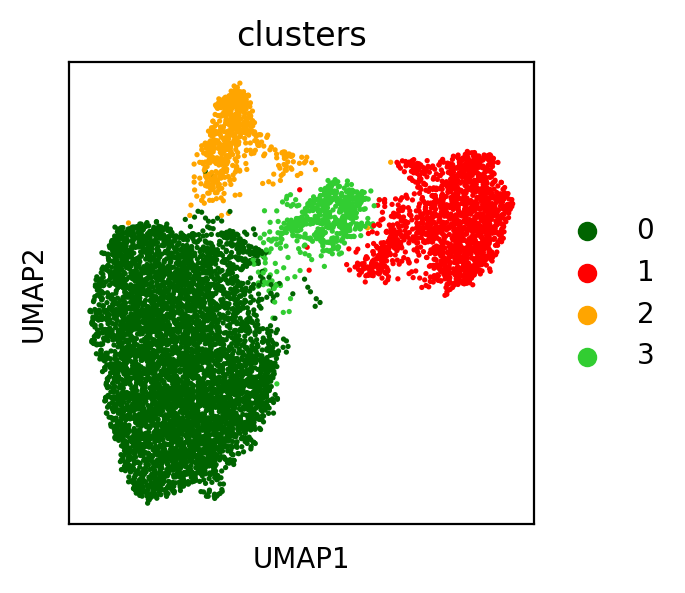

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(adata, color='clusters')

# Load tabula sapiens

In [4]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/adaptive_sampling/data/tabula_sapiens_filtered.h5ad"
sdf = sc.read_h5ad(fpath)

sc.pp.normalize_total(sdf, target_sum=1e6)

sdf

AnnData object with n_obs × n_vars = 27346 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

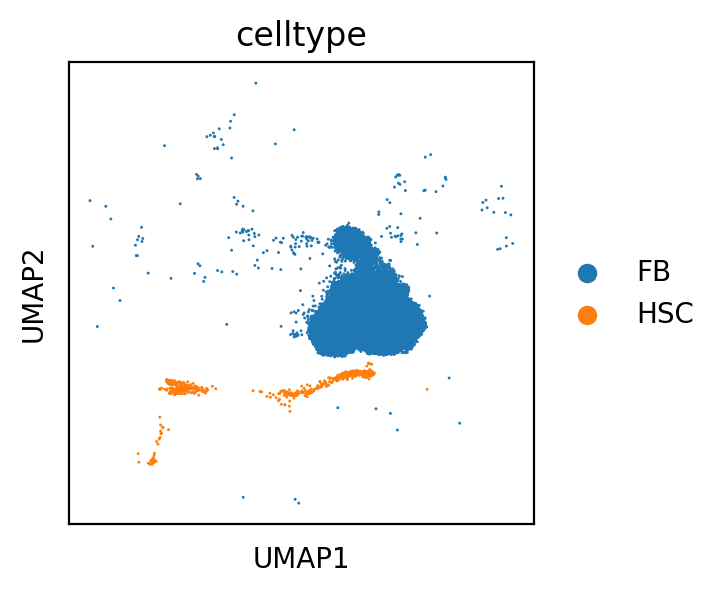

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(sdf, color='celltype')

In [6]:
sdf.obs[['celltype', 'organ_tissue']].value_counts()

celltype  organ_tissue   
FB        Fat                8459
          Vasculature        5867
          Bladder            5557
          Thymus             3924
          Trachea            1239
          Large_Intestine     953
HSC       Bone_Marrow         617
FB        Tongue              251
          Prostate            223
          Small_Intestine     113
HSC       Spleen               73
          Blood                70
dtype: int64

# get gene set

In [7]:
our_genes = adata.var.copy()
our_genes = our_genes.reset_index(drop=False)
ref_genes = sdf.var.copy()
ref_genes = ref_genes.reset_index(drop=False)

common_genes = np.intersect1d(our_genes['gene_name'].to_list(),
                              ref_genes['gene_symbol'].to_list(),)

print(f"{len(common_genes)=}")


gene_df = pd.merge(our_genes, ref_genes,
                   how='left', 
                   left_on='gene_name',
                   right_on='gene_symbol')

gene_df = gene_df[(gene_df['gene_name'].isin(common_genes)) & (gene_df['gene_symbol'].isin(common_genes))]
gene_df = gene_df[['gene_id', 'gene_name', 'Chromosome', 'Start', 'End',]]
gene_df = gene_df.drop_duplicates()
gene_df = gene_df.sort_values(by=['Chromosome', 'Start'])
gene_df = gene_df.reset_index(drop=True)
gene_df = gene_df.reset_index(drop=False)

print(f"{gene_df.shape=}")
gene_df.head()

len(common_genes)=13598
gene_df.shape=(13598, 6)


,index,gene_id,gene_name,Chromosome,Start,End
0,0,ENSG00000186092,OR4F5,1,65418,71585
1,1,ENSG00000284733,OR4F29,1,450739,451678
2,2,ENSG00000284662,OR4F16,1,685715,686654
3,3,ENSG00000187634,SAMD11,1,923922,944575
4,4,ENSG00000188976,NOC2L,1,944202,959309


# HSC Signature plot

In [43]:
def get_signature_data(sdf, gene_df, celltype='HSC', chroms=['19']):
    """A function to get the mean expression of 
    genes from the reference for a specific set of contigs"""

    mask = (sdf.obs['celltype'] == celltype)

    subset = sdf[mask, gene_df['gene_name'].to_list()].to_df()
    sig = subset.agg(['mean'], axis=0).T
    sig = sig.reset_index(drop=False)
    sig = sig.rename(columns={'index' : 'gene_name'})
    sig = pd.merge(sig, 
               gene_df,
               how='left',
               left_on='gene_name',
               right_on='gene_name')
    
    sig = sig[~sig['Chromosome'].isin(['GL000194.1', 'MT', 'X', 'Y'])]
    sig = sig[sig['Chromosome'].isin(chroms)]
    sig['Chromosome'] = sig['Chromosome'].astype(str)

    return sig

sig = get_signature_data(sdf, 
                         gene_df, 
                         celltype='HSC', 
                         chroms=['19'])
sig.head()

,gene_name,mean,index,gene_id,Chromosome,Start,End
11855,OR4F17,0.981916,11855,ENSG00000176695,19,107103,117102
11856,MIER2,22.188269,11856,ENSG00000105556,19,305572,344815
11857,SHC2,7.513282,11857,ENSG00000129946,19,416588,461033
11858,MADCAM1,10.805145,11858,ENSG00000099866,19,489175,505343
11859,TPGS1,92.244591,11859,ENSG00000141933,19,507496,519654


,gene_name,mean,index,gene_id,Chromosome,Start,End
11855,OR4F17,0.981916,11855,ENSG00000176695,19,107103,117102
11856,MIER2,22.188269,11856,ENSG00000105556,19,305572,344815
11857,SHC2,7.513282,11857,ENSG00000129946,19,416588,461033
11858,MADCAM1,10.805145,11858,ENSG00000099866,19,489175,505343
11859,TPGS1,92.244591,11859,ENSG00000141933,19,507496,519654


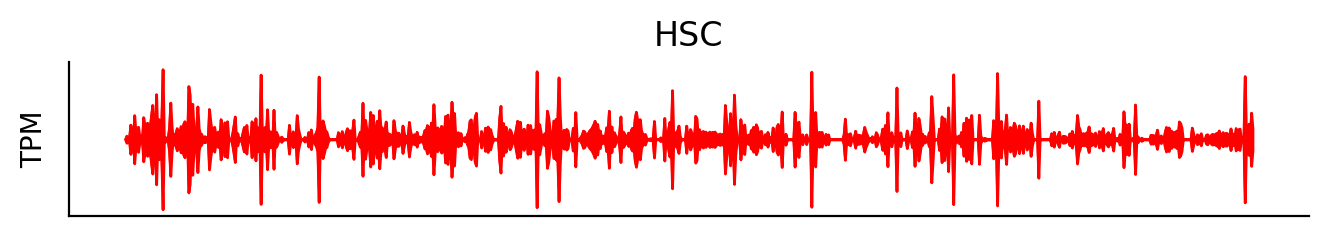

In [78]:
celltype = 'HSC'
sig = get_signature_data(sdf, 
                         gene_df, 
                         celltype=celltype, 
                         chroms=['19'])

color = 'red'

# add the negative signal
sig2 = sig.copy()
sig2['mean'] = -1 * sig2['mean']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 1

sns.lineplot(data=sig, 
             x='index',
             y='mean',
             color=color,
             lw=0.5,
             zorder=2)

sns.lineplot(data=sig2, 
             x='index',
             y='mean',
             color=color,
             lw=0.5,
             zorder=2)

plt.fill_between(sig2['index'], 
                 sig2['mean'], 
                 sig['mean'],
                 color=color,
                 zorder=1)

plt.title(celltype)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("")
plt.ylabel("TPM")
sns.despine()


sig.head()

,gene_name,mean,index,gene_id,Chromosome,Start,End
11855,OR4F17,0.923521,11855,ENSG00000176695,19,107103,117102
11856,MIER2,20.205524,11856,ENSG00000105556,19,305572,344815
11857,SHC2,97.202118,11857,ENSG00000129946,19,416588,461033
11858,MADCAM1,4.956719,11858,ENSG00000099866,19,489175,505343
11859,TPGS1,133.464706,11859,ENSG00000141933,19,507496,519654


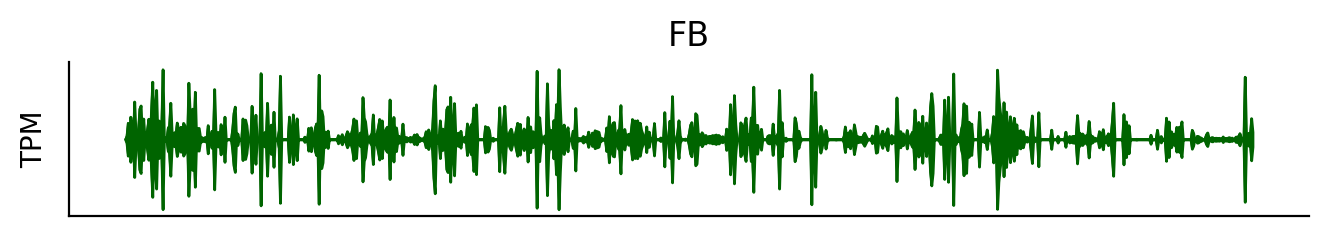

In [68]:
celltype = 'FB'
sig = get_signature_data(sdf, 
                         gene_df, 
                         celltype=celltype, 
                         chroms=['19'])

color = 'darkgreen'

# add the negative signal
sig2 = sig.copy()
sig2['mean'] = -1 * sig2['mean']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 1

sns.lineplot(data=sig, 
             x='index',
             y='mean',
             color=color,
             lw=0.5,
             zorder=2)

sns.lineplot(data=sig2, 
             x='index',
             y='mean',
             color=color,
             lw=0.5,
             zorder=2)

plt.fill_between(sig2['index'], 
                 sig2['mean'], 
                 sig['mean'],
                 color=color,
                 zorder=1)

plt.title(celltype)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("")
plt.ylabel("TPM")
sns.despine()


sig.head()

# Greatest Differences

In [79]:
sig_hsc = get_signature_data(sdf, gene_df, celltype='HSC', chroms=['19'])
sig_hsc = sig_hsc.rename(columns={'mean' : 'hsc_mean'})

sig_fb = get_signature_data(sdf, gene_df, celltype='FB', chroms=['19'])
sig_fb = sig_fb.rename(columns={'mean' : 'fb_mean'})

sig = pd.merge(sig_hsc, 
               sig_fb[['gene_name', 'fb_mean']],
               how='inner',
               left_on='gene_name',
               right_on='gene_name')

sig['diff'] = sig['fb_mean'] - sig['hsc_mean']
sig = sig.sort_values(by='diff', ascending=False)

cols = [
    'gene_name',
    'diff',
    'hsc_mean',
    'fb_mean',
    'Start'
]

print(sig[cols].head(15))
print()
print(sig[cols].tail(15))

    gene_name        diff   hsc_mean     fb_mean     Start
120        C3  376.409120   0.064299  376.473419   6677703
54    GADD45B  262.696934  18.505276  281.202209   2476121
240      JUNB  239.593674  80.365463  319.959137  12791485
507     LTBP4  237.118511  54.808155  291.926666  40592882
487     ZFP36  233.024765  78.488571  311.513336  39406846
69       NFIC  218.784294  78.065498  296.849792   3314402
205     KANK2  202.264961  33.390388  235.655350  11164269
252      NFIX  197.896046  53.742001  251.638046  12995474
681      RRAS  187.678596  31.380394  219.058990  49635291
677     FCGRT  187.334030  65.569870  252.903900  49506815
12       PALM  174.656775  25.235239  199.892014    708934
678      RCN3  174.642624   1.118408  175.761032  49528002
152   ANGPTL4  170.665772   0.072356  170.738129   8363288
11      FSTL3  161.264734  19.018484  180.283218    676391
294      KLF2  159.607151  38.806576  198.413727  16324825

    gene_name        diff    hsc_mean     fb_mean     S

# Plot single-cells

In [84]:
def get_cluster_data(adata, gene_df, cluster='C2', chroms=['19'], sample=50):
    mask = (adata.obs['cluster_name'] == cluster)
    cells = adata[mask, gene_df['gene_id'].to_list()].to_df()
    cells = cells.sample(sample)
    cells = cells.reset_index(drop=False)
    cells = pd.melt(cells, id_vars='cell_id')
    
    cells = pd.merge(cells, 
                 gene_df,
                 how='left',
                 left_on='gene_id',
                 right_on='gene_id')
    
    cells = cells[cells['Chromosome'].isin(chroms)]
    cells['Chromosome'] = cells['Chromosome'].astype(str)
    return cells


cells = get_cluster_data(adata,
                         gene_df, 
                         cluster='C2', 
                         chroms=['19'])

cells.head()

,cell_id,gene_id,value,index,gene_name,Chromosome,Start,End
592750,TGGAACTAGAACTCCT,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
592751,CTGAATGCAGCAGTAG,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
592752,TGTTTGTTCTAGGAAA,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
592753,TCACTATAGCAGAAAG,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
592754,CACAGGCAGATTGGGC,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102


,cell_id,gene_id,value,index,gene_name,Chromosome,Start,End
592750,TCTTCCTAGGTCTACT,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
592751,ATCACTTTCATGAGAA,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
592752,GATGCTATCCGAAATC,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
592753,AAGGTAAGTACGACTT,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
592754,ACATGCATCAGGAAAT,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102


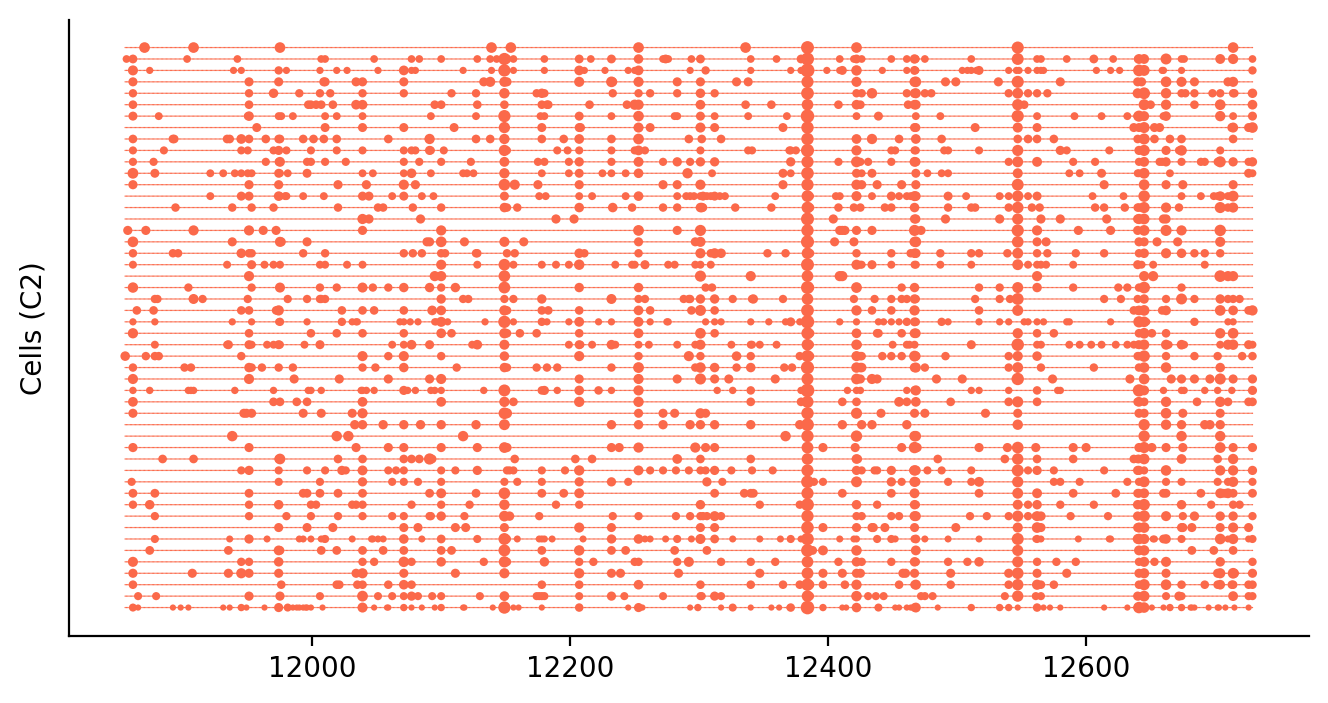

In [85]:
cmap = "Reds"
cluster = "C2"
# hsc single cells
cells = get_cluster_data(adata,
                         gene_df, 
                         cluster=cluster, 
                         chroms=['19'])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

sns.scatterplot(data=cells,
                x='index',
                y='cell_id',
                palette=cmap,
                marker=".",
                # s=10,
                ec='none',
                size='value',
                sizes=(1, 100),
                hue='Chromosome')

plt.yticks([], [])

plt.xlabel("")
plt.ylabel(f"Cells ({cluster})")
ax = plt.gca()
ax.legend().remove()

# ax_divider = make_axes_locatable(ax)
# ax2 = ax_divider.append_axes("top", size="15%", pad="5%")
# sns.lineplot(data=sig, 
#              x='index',
#              y='mean',
#              lw=0.5, 
#              palette=cmap,
#              hue='Chromosome',
#              ax=ax2)

# ax2.set_xlabel("")
# ax2.set_ylabel("")
# ax2.set_yticks([])

# ax2.legend().remove()
# ax2.sharex(ax)
# # ax2.set_xticks([])


sns.despine()

cells.head()


# Plot both 

In [90]:
cells.head()

,cell_id,gene_id,value,index,gene_name,Chromosome,Start,End
118550,TGAGTCAAGAGAACCC,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
118551,GGAACCCCAAGATCCT,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
118552,CATACTTGTGCCAAGA,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
118553,CTCAACCGTGACGCCT,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102
118554,AAGTACCTCTGTTGGA,ENSG00000176695,0.0,11855,OR4F17,19,107103,117102


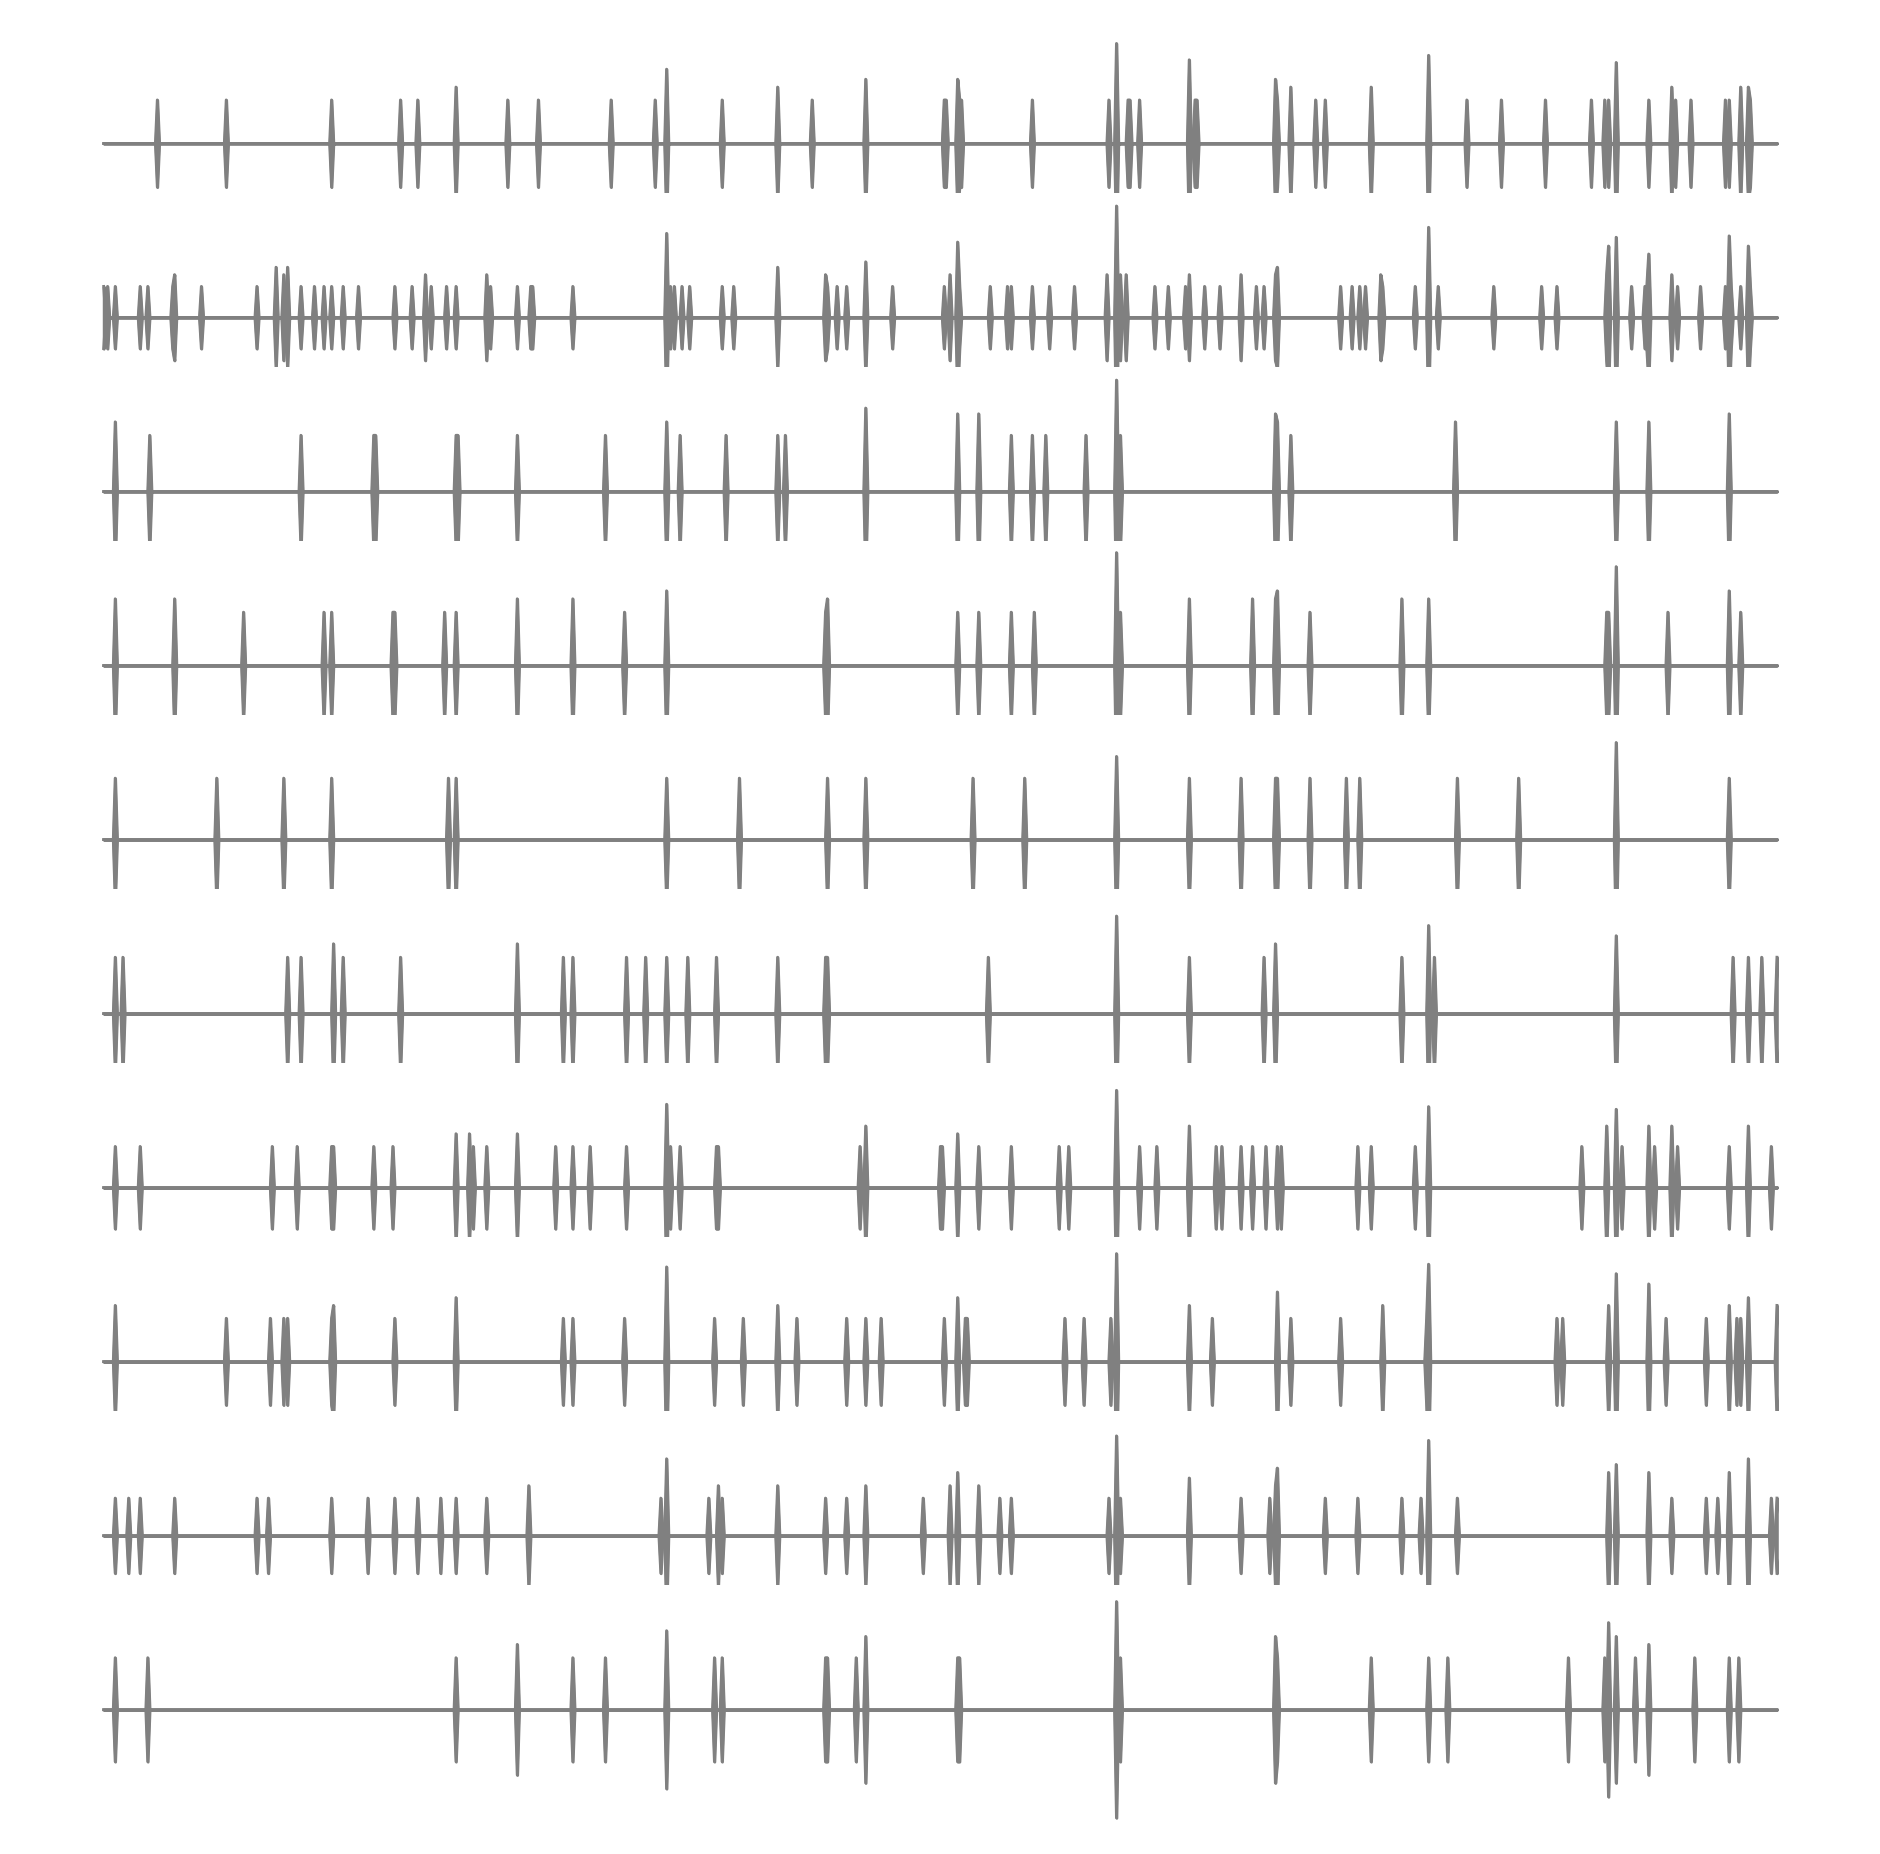

In [117]:
cluster = "C2"
sample = 10
lw = 1
color = "grey"

# hsc single cells
cells = get_cluster_data(adata,
                         gene_df, 
                         cluster=cluster, 
                         chroms=['19'],
                         sample=sample)
# add negatives
cells['value_neg'] = cells['value'] * -1

g = sns.FacetGrid(cells, 
                  row="cell_id",
                  # hue="", 
                  aspect=10, 
                  height=sample*0.1, 
                  sharex=True)

g.map(sns.lineplot, 
      "index", 
      "value", 
      linewidth=lw, 
      color=color)

g.map(sns.lineplot, 
      "index",
      "value_neg", 
      linewidth=lw, 
      color=color)

g.map(plt.fill_between, 
      "index",
      "value", 
      "value_neg", 
      color=color)

g.set_titles("")
g.set(yticks=[], ylabel="", xticks=[], xlabel="")
g.despine(bottom=True, left=True)
g.figure.subplots_adjust(hspace=-.3)


# plt.title(celltype)
# plt.xticks([], [])
# plt.yticks([], [])
# plt.xlabel("")
# plt.ylabel("TPM")
# sns.despine()


In [ ]:
def get_closest_cells(adata, sig, n=10, metric='euclidean'):
    """Get the n closest cells by metric """
    

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)